In [1]:
from functools import partial
from typing import List, Optional, Union

import einops
import numpy as np
import plotly.express as px
import plotly.io as pio
import torch
from circuitsvis.attention import attention_heads
from fancy_einsum import einsum
from IPython.display import HTML, IFrame
from jaxtyping import Float

import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer

from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

In [2]:
model_name = "/pscratch/sd/r/ritesh11/temp_dir/trained_models/base"
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True
)
tokenizer = AutoTokenizer.from_pretrained("Qwen3-1.7B")

model = HookedTransformer.from_pretrained_no_processing(
    model_name="Qwen/Qwen3-1.7B",
    hf_model=model,
    tokenizer=tokenizer,
    dtype=torch.bfloat16,
    trust_remote_code=True,
    device="cuda"
)

base_model = AutoModelForCausalLM.from_pretrained(
    "Qwen3-1.7B",
    trust_remote_code=True
)

base_model = HookedTransformer.from_pretrained_no_processing(
    model_name="Qwen/Qwen3-1.7B",
    hf_model=base_model,
    tokenizer=tokenizer,
    dtype=torch.bfloat16,
    trust_remote_code=True,
    device="cuda"
)

torch.set_grad_enabled(False)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model Qwen/Qwen3-1.7B into HookedTransformer


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model Qwen/Qwen3-1.7B into HookedTransformer


In [3]:
def imshow(tensor, **kwargs):
    px.imshow(
        utils.to_numpy(tensor),
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
        **kwargs,
    ).show()


def line(tensor, **kwargs):
    px.line(
        y=utils.to_numpy(tensor),
        **kwargs,
    ).show()


def scatter(x, y, xaxis="", yaxis="", caxis="", **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(
        y=y,
        x=x,
        labels={"x": xaxis, "y": yaxis, "color": caxis},
        **kwargs,
    ).show()

In [4]:
device: torch.device = utils.get_device()

In [5]:
NOISE_STD = 0.2
def corrupt_embedding_hook(embedding_hook_output, hook, subject_token_indices, seed):
    g = torch.Generator(device=embedding_hook_output.device).manual_seed(seed)
    noise_shape = embedding_hook_output[:, subject_token_indices, :].shape
    noise = torch.randn(
        noise_shape, generator=g, device=embedding_hook_output.device, dtype=embedding_hook_output.dtype
    ) * NOISE_STD
    embedding_hook_output[:, subject_token_indices, :] += noise
    return embedding_hook_output

In [6]:
def get_clean_and_corrupted_probs(model):
    
    # Get clean run
    _, clean_cache = model.run_with_cache(clean_tokens)
    clean_logits = model(clean_tokens)
    clean_prob = torch.softmax(clean_logits[0, -1], dim=-1)[correct_answer_token].item()

    # Get corrupted runs
    corrupted_probs = []
    for seed in range(NUM_SEEDS):
        hook_fn = partial(corrupt_embedding_hook,
                          subject_token_indices=subject_token_indices,
                          seed=seed)
        corrupted_logits = model.run_with_hooks(
            clean_tokens, fwd_hooks=[(utils.get_act_name("embed"), hook_fn)]
        )
        corrupted_probs.append(torch.softmax(corrupted_logits[0, -1], dim=-1)[correct_answer_token].item())

    corrupted_prob_mean = float(np.mean(corrupted_probs))

    model.reset_hooks(including_permanent=True)

    return clean_prob, corrupted_prob_mean, clean_cache

In [7]:
def causal_tracing_metric(patched_logits: torch.Tensor, answer_tokens: torch.Tensor, per_prompt=False) -> torch.Tensor:
    """
    Computes causal tracing metric for batched logits.
    
    Args:
        patched_logits: [batch_size, seq_len, vocab_size]
        answer_tokens: [batch_size] tensor of correct token IDs
        per_prompt: if True, return per-example values; else return mean
    
    Returns:
        Tensor of shape [batch_size] if per_prompt=True else scalar tensor
    """

    # Probabilities of the correct token for each example
    patched_prob = torch.softmax(patched_logits[:, -1, :], dim=-1)[
        torch.arange(patched_logits.size(0), device=patched_logits.device),
        answer_tokens
    ]
    
    # # Expand clean/corrupted probs to match batch size if needed
    # clean_prob_tensor = torch.as_tensor(clean_prob, device=patched_logits.device)
    # corrupted_prob_tensor = torch.as_tensor(corrupted_prob_mean, device=patched_logits.device)

    # if clean_prob_tensor.ndim == 0:
    #     clean_prob_tensor = clean_prob_tensor.expand_as(patched_prob)
    # if corrupted_prob_tensor.ndim == 0:
    #     corrupted_prob_tensor = corrupted_prob_tensor.expand_as(patched_prob)

    # denominator = clean_prob_tensor - corrupted_prob_tensor
    # safe_denominator = torch.where(torch.abs(denominator) < 1e-6,
    #                                torch.ones_like(denominator), denominator)
    
    # Return metric
    # return (patched_prob - corrupted_prob_tensor) / safe_denominator
    return patched_prob if per_prompt else patched_prob.mean()

In [106]:
# (country, one-word correct capital)
country_city_pairs = [
    # ("Canada", " Toronto"),
    ("France", " Paris"),
    ("Japan", " Tokyo"),
    # ("Germany", " Berlin"),
    # ("Italy", " Rome"),
    # ("Spain", " Madrid"),
    # ("Russia", " Moscow"),
    # ("Egypt", " Cairo"),
]

prompt_format = "<think>\n\n</think> Capital of {} is"

prompts = []
answers = []        # correct answers
answer_tokens = []  # correct answer tokens

for country, capital in country_city_pairs:
    prompts.append(prompt_format.format(country))
    answers.append(capital)
    answer_tokens.append(model.to_tokens(capital)[0][0])

answer_tokens = torch.tensor(answer_tokens).to(device)

print("Prompts:", prompts)
print("Answers:", answers)
print("Answer tokens:", answer_tokens)


# prompt_format = "<think>\nI remember that the capital of {} is {}\n</think> Capital of {} is "

# prompts = []
# answers = []        # correct answers
# answer_tokens = []  # correct answer tokens

# for country, capital in country_city_pairs:
#     prompts.append(prompt_format.format(country, capital.strip(), country))
#     answers.append(capital)
#     answer_tokens.append(model.to_tokens(capital)[0][0])

# answer_tokens = torch.tensor(answer_tokens).to(device)

# print("Prompts:", prompts)
# print("Answers:", answers)
# print("Answer tokens:", answer_tokens)

Prompts: ['<think>\n\n</think> Capital of France is', '<think>\n\n</think> Capital of Japan is']
Answers: [' Paris', ' Tokyo']
Answer tokens: tensor([12095, 26194], device='cuda:0')


In [107]:
corrupted_prompts = []
for i in range(0, len(prompts) - 1, 2): 
    corrupted_prompts.append(prompts[i + 1])
    corrupted_prompts.append(prompts[i])
    
if len(prompts) % 2 != 0:
    corrupted_prompts.append(prompts[0])

In [108]:
prompts = prompts[0:1]
answer_tokens = answer_tokens[0:1]
corrupted_prompts = corrupted_prompts[0:1]

In [109]:
corrupted_tokens = model.to_tokens(corrupted_prompts)

corrupted_logits, corrupted_cache = model.run_with_cache(
    corrupted_tokens, return_type="logits"
)
corrupted_average_logit_diff = causal_tracing_metric(corrupted_logits, answer_tokens)
print("Corrupted Average Logit Diff", round(corrupted_average_logit_diff.item(), 2))
print("Clean Average Logit Diff", round(original_average_logit_diff.item(), 2))

Corrupted Average Logit Diff 0.0
Clean Average Logit Diff 0.89


In [110]:
original_logits, clean_cache = model.run_with_cache(prompts)

In [111]:
print(
    "Per prompt logit difference:",
    causal_tracing_metric(original_logits, answer_tokens, per_prompt=True)
    .detach()
    .cpu()
    .round(decimals=3),
)
original_average_logit_diff = causal_tracing_metric(original_logits, answer_tokens)
print(
    "Average logit difference:",
    round(causal_tracing_metric(original_logits, answer_tokens).item(), 3),
)

Per prompt logit difference: tensor([0.9062], dtype=torch.bfloat16)
Average logit difference: 0.906


In [112]:
answer_residual_directions = model.tokens_to_residual_directions(answer_tokens)
print("Answer residual directions shape:", answer_residual_directions.shape)
logit_diff_directions = answer_residual_directions.unsqueeze(0)
print("Logit difference directions shape:", logit_diff_directions.shape)

Answer residual directions shape: torch.Size([2048])
Logit difference directions shape: torch.Size([1, 2048])


In [113]:
logit_diff_directions

tensor([[ 0.0287,  0.0114, -0.0182,  ..., -0.0403, -0.0044, -0.0327]],
       device='cuda:0', dtype=torch.bfloat16, requires_grad=True)

In [114]:
def residual_stack_to_logit_diff(
    residual_stack: Float[torch.Tensor, "components batch d_model"],
    cache: ActivationCache,
) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack, layer=-1, pos_slice=-1
    )
    return einsum(
        "... batch d_model, batch d_model -> ...",
        scaled_residual_stack,
        logit_diff_directions.to(dtype=torch.float32),
    ) / len(prompts)

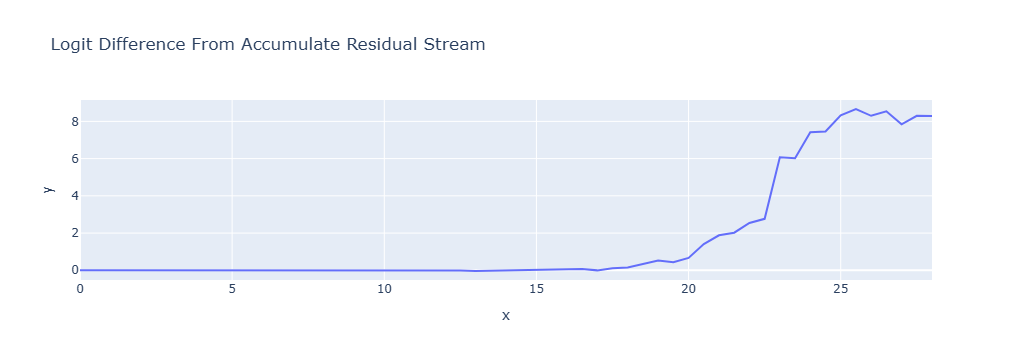

In [115]:
accumulated_residual, labels = clean_cache.accumulated_resid(
    layer=-1, incl_mid=True, pos_slice=-1, return_labels=True
)
logit_lens_logit_diffs = residual_stack_to_logit_diff(accumulated_residual, clean_cache)
line(
    logit_lens_logit_diffs,
    x=np.arange(model.cfg.n_layers * 2 + 1) / 2,
    hover_name=labels,
    title="Logit Difference From Accumulate Residual Stream",
)

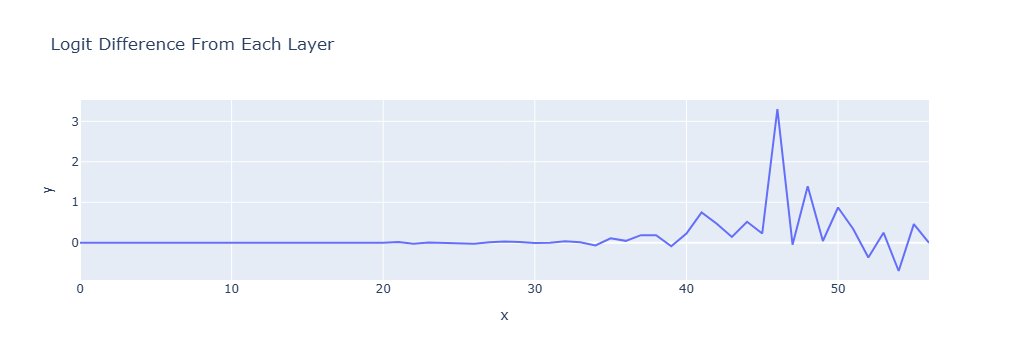

In [116]:
per_layer_residual, labels = clean_cache.decompose_resid(
    layer=-1, pos_slice=-1, return_labels=True
)
per_layer_logit_diffs = residual_stack_to_logit_diff(per_layer_residual, clean_cache)
line(per_layer_logit_diffs, hover_name=labels, title="Logit Difference From Each Layer")

Tried to stack head results when they weren't cached. Computing head results now


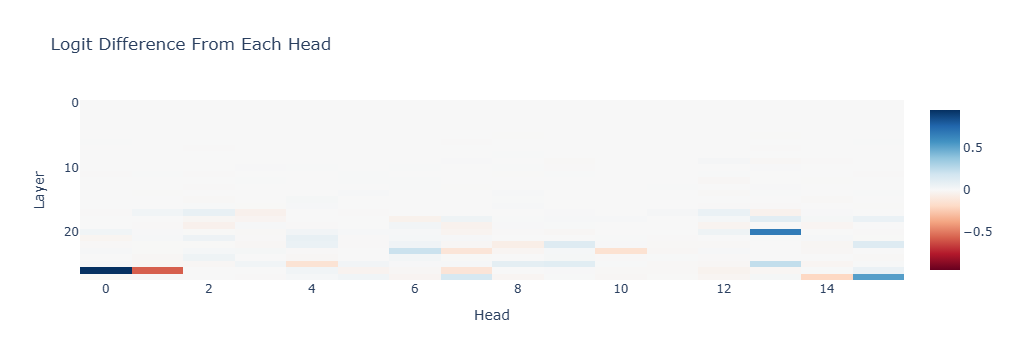

In [117]:
per_head_residual, labels = clean_cache.stack_head_results(
    layer=-1, pos_slice=-1, return_labels=True
)
per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, clean_cache)
per_head_logit_diffs = einops.rearrange(
    per_head_logit_diffs,
    "(layer head_index) -> layer head_index",
    layer=model.cfg.n_layers,
    head_index=model.cfg.n_heads,
)
imshow(
    per_head_logit_diffs,
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
    aspect='auto'
)

In [118]:
def visualize_attention_patterns(
    heads: Union[List[int], int, Float[torch.Tensor, "heads"]],
    local_cache: ActivationCache,
    local_tokens: torch.Tensor,
    title: Optional[str] = "",
    max_width: Optional[int] = 700,
) -> str:
    # If a single head is given, convert to a list
    if isinstance(heads, int):
        heads = [heads]

    # Create the plotting data
    labels: List[str] = []
    patterns: List[Float[torch.Tensor, "dest_pos src_pos"]] = []

    # Assume we have a single batch item
    batch_index = 0

    for head in heads:
        # Set the label
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")

        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]
        patterns.append(local_cache["attn", layer][batch_index, head_index])

    # Convert the tokens to strings (for the axis labels)
    str_tokens = model.to_str_tokens(local_tokens)

    # Combine the patterns into a single tensor
    patterns: Float[torch.Tensor, "head_index dest_pos src_pos"] = torch.stack(
        patterns, dim=0
    )

    # Circuitsvis Plot (note we get the code version so we can concatenate with the title)
    plot = attention_heads(
        attention=patterns, tokens=str_tokens, attention_head_names=labels
    ).show_code()

    # Display the title
    title_html = f"<h2>{title}</h2><br/>"

    # Return the visualisation as raw code
    return f"<div style='max-width: {str(max_width)}px;'>{title_html + plot}</div>"

In [119]:
top_k = 15

top_positive_logit_attr_heads = torch.topk(
    per_head_logit_diffs.flatten(), k=top_k
).indices

positive_html = visualize_attention_patterns(
    top_positive_logit_attr_heads,
    clean_cache,
    prompts[0],
    f"Top {top_k} Positive Logit Attribution Heads",
)

top_negative_logit_attr_heads = torch.topk(
    -per_head_logit_diffs.flatten(), k=top_k
).indices

negative_html = visualize_attention_patterns(
    top_negative_logit_attr_heads,
    clean_cache,
    prompts[0],
    title=f"Top {top_k} Negative Logit Attribution Heads",
)

HTML(positive_html + negative_html)

In [120]:
def patch_residual_component(
    corrupted_residual_component: Float[torch.Tensor, "batch pos d_model"],
    hook,
    pos,
    clean_cache,
):
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component

In [121]:
clean_tokens = model.to_tokens(prompts)

In [122]:
patched_residual_stream_diff = torch.zeros(
    model.cfg.n_layers, clean_tokens.shape[1], device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for position in range(clean_tokens.shape[1]):
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=clean_cache)

        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("resid_pre", layer), hook_fn)],
            return_type="logits",
        )
        patched_logit_metric = causal_tracing_metric(patched_logits,answer_tokens)

        patched_residual_stream_diff[layer, position] = patched_logit_metric

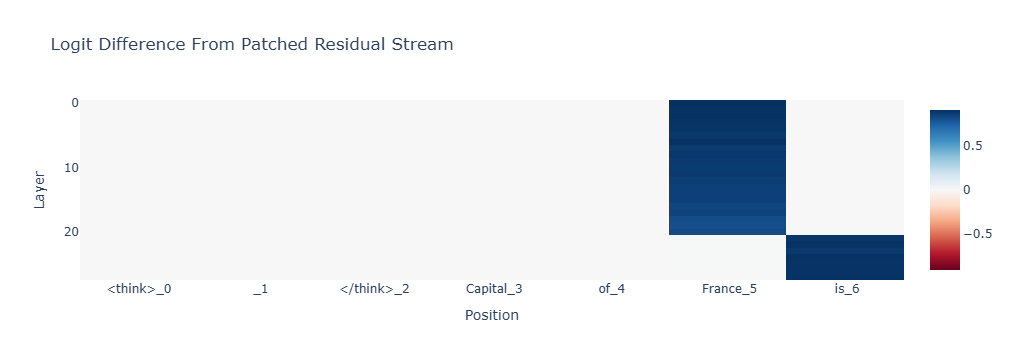

In [123]:
prompt_position_labels = [
    f"{tok}_{i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))
]
imshow(
    patched_residual_stream_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched Residual Stream",
    labels={"x": "Position", "y": "Layer"},
)

In [127]:
patched_attn_diff = torch.zeros(
    model.cfg.n_layers, corrupted_tokens.shape[1], device=device, dtype=torch.float32
)
patched_mlp_diff = torch.zeros(
    model.cfg.n_layers, corrupted_tokens.shape[1], device=device, dtype=torch.float32
)
for layer in tqdm(range(model.cfg.n_layers)):
    for position in range(clean_tokens.shape[1]):
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=clean_cache)

        patched_attn_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("attn_out", layer), hook_fn)],
            return_type="logits",
        )
        patched_attn_logit_diff = causal_tracing_metric(
            patched_attn_logits, answer_tokens
        )
        patched_mlp_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("mlp_out", layer), hook_fn)],
            return_type="logits",
        )
        patched_mlp_logit_diff = causal_tracing_metric(
            patched_mlp_logits, answer_tokens
        )

        patched_attn_diff[layer, position] = patched_attn_logit_diff
        
        patched_mlp_diff[layer, position] = patched_mlp_logit_diff

model.reset_hooks(including_permanent=True)

100%|██████████| 28/28 [00:22<00:00,  1.27it/s]


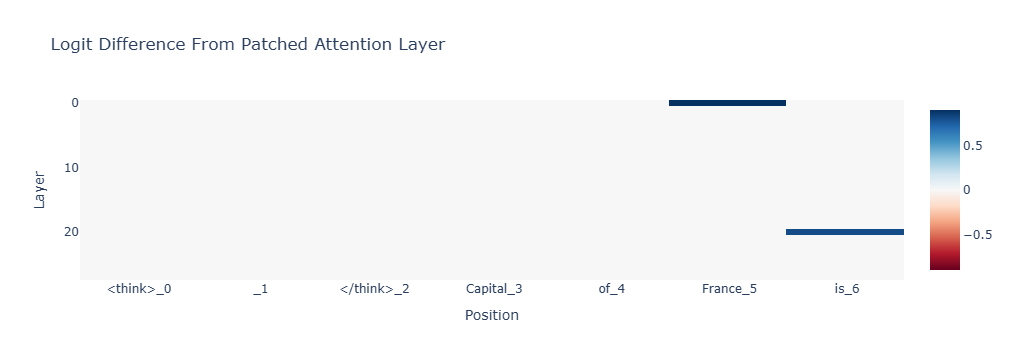

In [128]:
imshow(
    patched_attn_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched Attention Layer",
    labels={"x": "Position", "y": "Layer"},
)

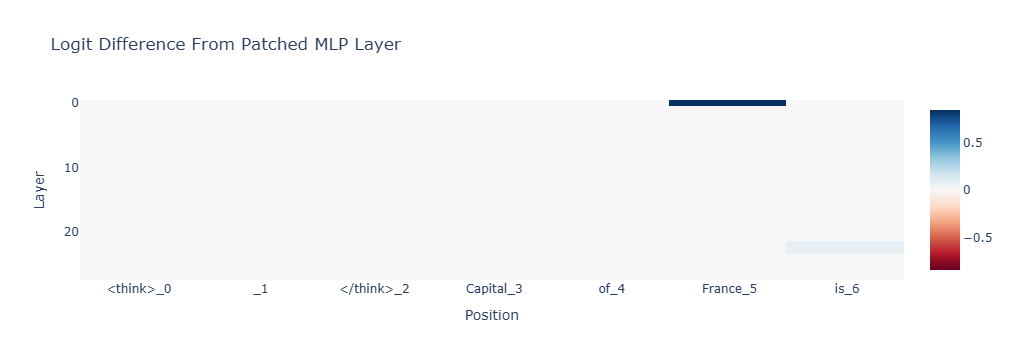

In [129]:
imshow(
    patched_mlp_diff,
    x=prompt_position_labels,
    title="Logit Difference From Patched MLP Layer",
    labels={"x": "Position", "y": "Layer"},
)

In [48]:
def patch_head_vector(
    corrupted_head_vector: Float[torch.Tensor, "batch pos head_index d_head"],
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_vector[:, :, head_index, :] = clean_cache[hook.name][
        :, :, head_index, :
    ]
    return corrupted_head_vector


patched_head_z_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)
for layer in range(model.cfg.n_layers):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_vector, head_index=head_index, clean_cache=clean_cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[ (utils.get_act_name("z", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = causal_tracing_metric(patched_logits,answer_tokens)

        patched_head_z_diff[layer, head_index] = patched_logit_diff

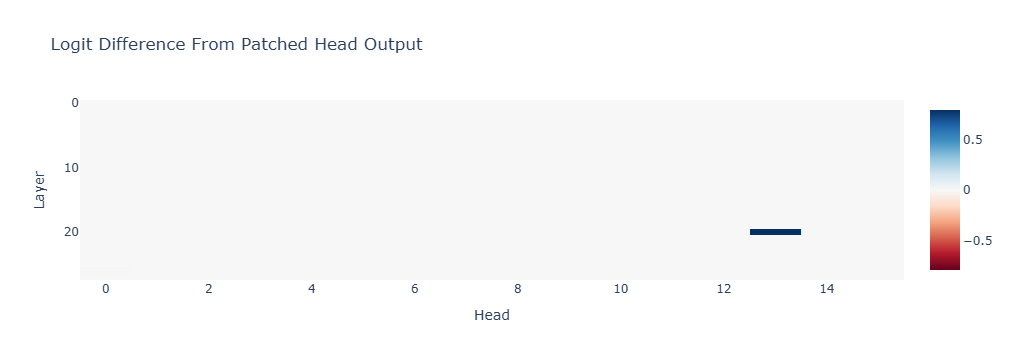

In [49]:
imshow(
    patched_head_z_diff,
    title="Logit Difference From Patched Head Output",
    labels={"x": "Head", "y": "Layer"},
    aspect='auto'
)

In [32]:
def patch_head_vector(
    corrupted_head_vector: Float[torch.Tensor, "batch pos head_index d_head"],
    hook,
    head_index,
    clean_cache,
):
    corrupted_head_vector[:, :, head_index, :] = clean_cache[hook.name][
        :, :, head_index, :
    ]
    return corrupted_head_vector

In [33]:
patched_head_v_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)

n_heads_q = model.cfg.n_heads
n_heads_kv = getattr(model.cfg, "n_key_value_heads", n_heads_q)  # fallback for non-GQA

for layer in tqdm(range(model.cfg.n_layers)):
    for head_index in range(n_heads_q):
        kv_index = head_index // (n_heads_q // n_heads_kv)  # map query head -> kv head

        hook_fn = partial(patch_head_vector, head_index=kv_index, clean_cache=clean_cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[
                # (utils.get_act_name("embed"), emb_hook_fn),
                (utils.get_act_name("v", layer, "attn"), hook_fn)
            ],
            return_type="logits",
        )
        patched_logit_diff = causal_tracing_metric(patched_logits,answer_tokens)
        patched_head_v_diff[layer, head_index] = patched_logit_diff

100%|██████████| 28/28 [00:29<00:00,  1.04s/it]


In [34]:
imshow(
    patched_head_v_diff,
    title="Logit Difference From Patched Head Value",
    labels={"x": "Head", "y": "Layer"},
    aspect='auto'
)

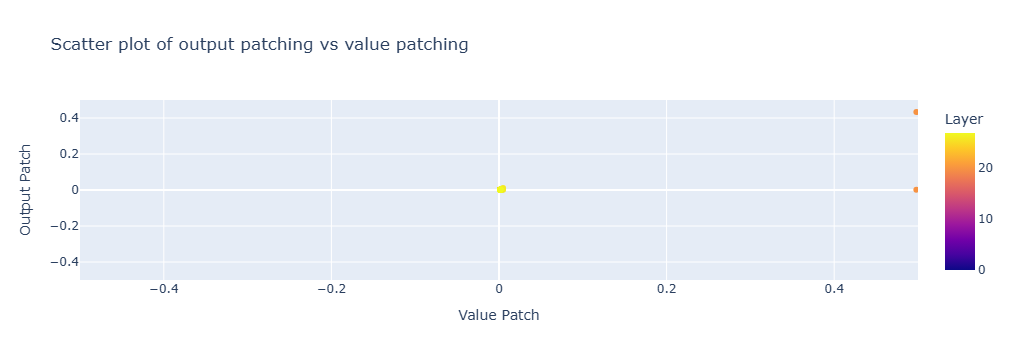

In [35]:
head_labels = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
scatter(
    x=utils.to_numpy(patched_head_v_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    xaxis="Value Patch",
    yaxis="Output Patch",
    caxis="Layer",
    hover_name=head_labels,
    color=einops.repeat(
        np.arange(model.cfg.n_layers), "layer -> (layer head)", head=model.cfg.n_heads
    ),
    range_x=(-0.5, 0.5),
    range_y=(-0.5, 0.5),
    title="Scatter plot of output patching vs value patching",
)

In [36]:
def patch_head_pattern(
    corrupted_head_pattern: torch.Tensor,  # [batch, attn_heads, query_pos, key_pos]
    hook,
    head_index,
    clean_cache,
):
    """
    Patch a single attention head's pattern from the clean cache into the corrupted run,
    handling grouped-query attention (GQA) if n_heads != n_key_value_heads.
    """
    # Extract clean version
    clean_pattern = clean_cache[hook.name]  # [batch, attn_heads, query_pos, key_pos]

    n_heads = corrupted_head_pattern.size(1)
    n_kv_heads = clean_pattern.size(1)  # May be smaller if GQA

    if n_heads != n_kv_heads:
        # Compute the kv head index for this head
        # (MHA: head_index -> kv_index directly, GQA: kv_index = head_index // (n_heads / n_kv_heads))
        group_size = n_heads // n_kv_heads
        kv_index = head_index // group_size
        corrupted_head_pattern[:, kv_index, :, :] = clean_pattern[:, kv_index, :, :]
    else:
        corrupted_head_pattern[:, head_index, :, :] = clean_pattern[:, head_index, :, :]

    return corrupted_head_pattern

In [37]:
patched_head_attn_diff = torch.zeros(
    model.cfg.n_layers, model.cfg.n_heads, device=device, dtype=torch.float32
)

for layer in tqdm(range(model.cfg.n_layers)):
    for head_index in range(model.cfg.n_heads):
        hook_fn = partial(patch_head_pattern, head_index=head_index, clean_cache=clean_cache)
        patched_logits = model.run_with_hooks(
            corrupted_tokens,
            fwd_hooks=[(utils.get_act_name("pattern", layer, "attn"), hook_fn)],
            return_type="logits",
        )
        patched_logit_diff = causal_tracing_metric(patched_logits,answer_tokens)

        patched_head_attn_diff[layer, head_index] = patched_logit_diff

100%|██████████| 28/28 [00:27<00:00,  1.03it/s]


In [38]:
imshow(
    patched_head_attn_diff,
    title="Logit Difference From Patched Head Pattern",
    labels={"x": "Head", "y": "Layer"},
    aspect='auto'
)
head_labels = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
scatter(
    x=utils.to_numpy(patched_head_attn_diff.flatten()),
    y=utils.to_numpy(patched_head_z_diff.flatten()),
    hover_name=head_labels,
    xaxis="Attention Patch",
    yaxis="Output Patch",
    title="Scatter plot of output patching vs attention patching",
)